# 🌀 Regularized State Space Model Training Demo

This notebook demonstrates training a state space model with symmetry regularization using Lie derivatives.

Key features:
- **ELBO Loss**: Standard variational inference objective
- **Lie Derivative Regularization**: Enforces symmetry constraints  
- **Curvature Regularization**: Optional smoothness constraint
- **Loss Monitoring**: Separate tracking of each loss component

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup
startupMode = 'dev'

if startupMode == 'colab':
    try:
        import xfads,jax,gpytorch
    except ImportError:
        %pip install --quiet pytorch-lightning hydra-core
        %pip install --quiet gpytorch
        %pip install git+https://github.com/catniplab/xfads
        %git clone https://github.com/catniplab/xfads
        %cd xfads/examples/ring_attractor
        config_path = "../content/xfads/examples/ring_attractor"
elif startupMode == 'dev':
    import sys
    sys.path.append('../..') # add path for xfads root

    %load_ext autoreload
    %autoreload 2
    config_path = ''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from pathlib import Path

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Timer
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Import our regularized SSM
from regularized_ssm import RegularizedSSM, create_rotation_vector_field

## ⚙️ Initialize Configuration

In [22]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path=config_path, job_name="lds")
cfg = compose(config_name="config")

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

Seed set to 1234


In [23]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

cfg['device'] = device
print(f"Using device: {device}")

cfg['n_epochs'] = 50  # Reduced epochs for testing
print(f"Training for {cfg['n_epochs']} epochs")

Using device: cpu
Training for 50 epochs


## 📈 Simulate Data

Generate data from a 2D ring attractor system with perturbations.

In [24]:
import importlib.util

file_path = "test_dynamics.py"
module_name = "test_dynamics"  # can be any name

spec = importlib.util.spec_from_file_location(module_name, file_path)
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

In [25]:
perturbation_magnitude=0.1

n_trials = 3000
n_neurons = 100
n_time_bins = 75


# Backup RNG states
cpu_state = torch.get_rng_state()
cuda_state = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
np_state = np.random.get_state()

mean_fn = PerturbedRingAttractorDynamics(bin_sz=1e-1,lengthscale=0.2,perturbation_magnitude=perturbation_magnitude).to(cfg.device)

# Restore RNG states
torch.set_rng_state(cpu_state)
if cuda_state is not None:
    torch.cuda.set_rng_state_all(cuda_state)
np.random.set_state(np_state)

C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)

Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=cfg.device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=cfg.device)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


## 📈 Visualize True Latent Trajectories

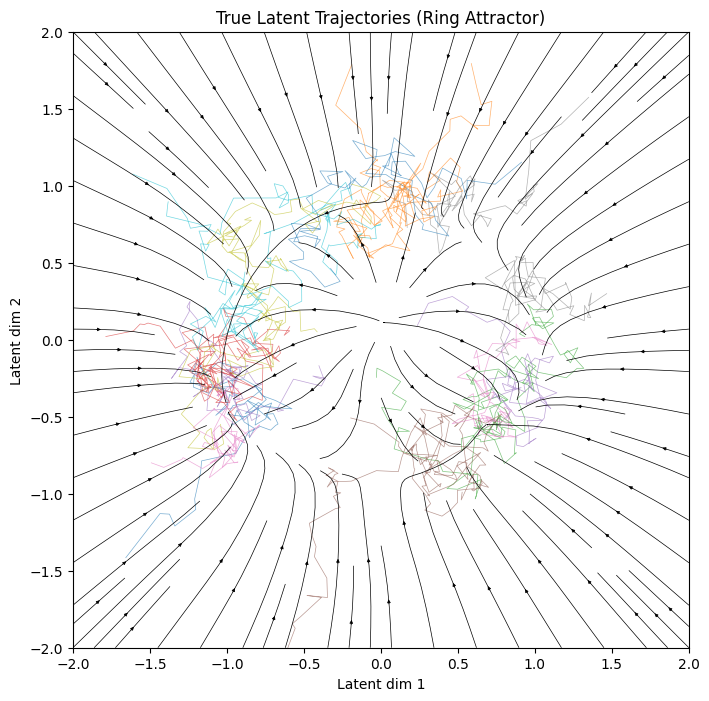

In [26]:
fig, axs = plt.subplots(figsize=(8, 8))
for i in range(20):  # Plot subset of trajectories
    axs.plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)

# Plot vector field
plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), axs, min_xy=-2, max_xy=2)
axs.set_title("True Latent Trajectories (Ring Attractor)")
axs.set_xlabel("Latent dim 1")
axs.set_ylabel("Latent dim 2")
axs.set_xlim(-2, 2)
axs.set_ylim(-2, 2)
axs.set_box_aspect(1.0)
plt.show()

# Save plot
fig.savefig(
    f'true_latent_traj_reg.png',
    dpi=300, bbox_inches='tight'
)

## 🔄 Prepare Train/Validation Dataloaders

In [27]:
def collate_fn(batch):
    elem = batch[0]
    if isinstance(elem, (tuple, list)):
        return tuple(torch.stack([b[i] for b in batch]).to(cfg.device) for i in range(len(elem)))
    else:
        return torch.stack(batch).to(cfg.device)

# Split data
split_idx = 2 * n_trials // 3
y_train, z_train = y[:split_idx], z[:split_idx]
y_valid, z_valid = y[split_idx:], z[split_idx:]

print(f"Training data: {y_train.shape}")
print(f"Validation data: {y_valid.shape}")

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), 
    batch_size=cfg.batch_sz, 
    shuffle=True, 
    collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), 
    batch_size=cfg.batch_sz, 
    shuffle=False, 
    collate_fn=collate_fn
)

Training data: torch.Size([2000, 75, 100])
Validation data: torch.Size([1000, 75, 100])


## 🧱 Define Model Components

In [28]:
# Likelihood
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, C)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=cfg.device, fix_R=True)

# Dynamics (learnable)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)

print("✅ Model components created")

✅ Model components created


## 🎯 Define Target Vector Field for Regularization

We'll use a simple rotation field as our target symmetry.

Target vector field test:
  Input shape: torch.Size([10, 2])
  Output shape: torch.Size([10, 2])


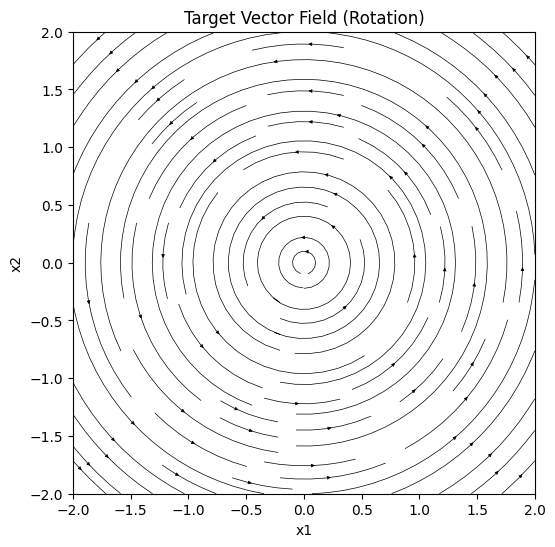

In [29]:
# Create target vector field (rotation)
target_vector_field = create_rotation_vector_field(rotation_speed=0.5)
dt = 1e-2
# Test the target field
test_points = torch.randn(10, 2)
test_output = target_vector_field(test_points)
print(f"Target vector field test:")
print(f"  Input shape: {test_points.shape}")
print(f"  Output shape: {test_output.shape}")

# Visualize target field
fig, ax = plt.subplots(figsize=(6, 6))
plot_utils.plot_two_d_vector_field(
    lambda x: x + dt * target_vector_field(x), ax, min_xy=-2, max_xy=2
)
ax.set_title("Target Vector Field (Rotation)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_box_aspect(1.0)
plt.show()

## 🧠 Create Regularized State Space Model

In [30]:
# Regularization parameters
lambda_lie = 0.0        # Weight for Lie derivative regularization
lambda_curvature = 0.1  # Weight for curvature regularization (optional)

# Create regularized SSM
regularized_ssm = RegularizedSSM(
    dynamics_mod=dynamics_mod,
    likelihood_pdf=likelihood_pdf, 
    initial_c_pdf=initial_condition_pdf,
    backward_encoder=backward_encoder, 
    local_encoder=local_encoder, 
    nl_filter=nl_filter,
    target_vector_field=target_vector_field,
    lambda_lie=lambda_lie,
    lambda_curvature=lambda_curvature,
    lie_normalize=False,  # Use Yang normalization
    curvature_order=1,
    device=cfg.device
)

print(f"✅ RegularizedSSM created with:")
print(f"  λ_lie = {lambda_lie}")
print(f"  λ_curvature = {lambda_curvature}")
print(f"  Lie normalization: yang")
print(f"  Device: {cfg.device}")

✅ RegularizedSSM created with:
  λ_lie = 0.0
  λ_curvature = 0.1
  Lie normalization: yang
  Device: cpu


## 🔬 Test Regularized Forward Pass

In [32]:
# Test forward pass with a small batch
test_batch = y_train[:2]  # Use 2 trials
print(f"Testing with batch shape: {test_batch.shape}")

with torch.no_grad():
    loss, z_samples, stats = regularized_ssm(test_batch, cfg.n_samples)

print(f"\n✅ Forward pass successful!")
print(f"  Total loss: {loss.item():.6f}")
print(f"  ELBO loss: {stats['elbo_loss'].item():.6f}")
print(f"  Lie loss: {stats['lie_loss'].item():.6f}")
print(f"  Curvature loss: {stats['curvature_loss'].item():.6f}")
print(f"  Total reg loss: {stats['total_reg_loss'].item():.6f}")
print(f"  Latent samples shape: {z_samples.shape}")

Testing with batch shape: torch.Size([2, 75, 100])

✅ Forward pass successful!
  Total loss: 23468.125000
  ELBO loss: 23460.164062
  Lie loss: 0.000000
  Curvature loss: 79.600700
  Total reg loss: 7.960070
  Latent samples shape: torch.Size([5, 2, 75, 2])


## 🔥 Training with Custom Loss Tracking

We'll create a custom Lightning module to properly track all loss components.

In [33]:
from in_progress.regularized_ssm import RegularizedLightningSSM

# Create the Lightning module
seq_vae = RegularizedLightningSSM(regularized_ssm, cfg)
print("✅ Custom Lightning module created")

✅ Custom Lightning module created


/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'regularized_ssm' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['regularized_ssm'])`.


## 🚀 Train the Regularized Model

In [34]:
# Set up logging and callbacks
csv_logger = CSVLogger(
    'logs_regularized/', 
    name=f'reg_lie_{lambda_lie}_curv_{lambda_curvature}', 
    version='regularized'
)

ckpt_callback = ModelCheckpoint(
    save_top_k=3, 
    monitor='valid_loss', 
    mode='min',
    dirpath='ckpts_regularized/', 
    filename='{epoch:02d}_{valid_loss:.4f}'
)

early_stop_callback = EarlyStopping(
    monitor="valid_elbo",
    min_delta=0.001, 
    patience=10, 
    verbose=True, 
    mode="min"
)

timer = Timer()

# Create trainer
trainer = pl.Trainer(
    max_epochs=cfg.n_epochs,
    gradient_clip_val=1.0,
    default_root_dir='lightning_regularized/',
    callbacks=[ckpt_callback, timer, early_stop_callback],
    accelerator=cfg.device,
    logger=csv_logger,
    log_every_n_steps=10
)

print(f"🚀 Starting training for {cfg.n_epochs} epochs...")
print(f"   Monitoring: ELBO + Lie + Curvature losses")
print(f"   Saving checkpoints to: ckpts_regularized/")
print(f"   Logging to: logs_regularized/")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🚀 Starting training for 50 epochs...
   Monitoring: ELBO + Lie + Curvature losses
   Saving checkpoints to: ckpts_regularized/
   Logging to: logs_regularized/


/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [35]:
# Start training
trainer.fit(
    model=seq_vae, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,

)

# Save best model path
torch.save(ckpt_callback.best_model_path, 'ckpts_regularized/best_model_path.pt')
print(f"\n✅ Training completed!")
print(f"   Best model: {ckpt_callback.best_model_path}")
print(f"   Training time: {timer.time_elapsed('train'):.1f}s")
print(f"   Validation time: {timer.time_elapsed('validate'):.1f}s")

/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:45: Attribute 'regularized_ssm' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['regularized_ssm'])`.
/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/piotr/dev/symm_reg/in_progress/ckpts_regularized exists and is not empty.

  | Name | Type           | Params | Mode 
------------------------------------------------
0 | ssm  | RegularizedSSM | 41.2 K | train
------------------------------------------------
40.9 K    Trainable params
300       Non-trainable params
41.2 K    Total params
0.165     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved. New best score: 18761.920


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 965.846 >= min_delta = 0.001. New best score: 17796.074


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 6998.562 >= min_delta = 0.001. New best score: 10797.513


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 3795.816 >= min_delta = 0.001. New best score: 7001.696


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 3682.059 >= min_delta = 0.001. New best score: 3319.637


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 360.377 >= min_delta = 0.001. New best score: 2959.260


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 251.176 >= min_delta = 0.001. New best score: 2708.084


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 77.017 >= min_delta = 0.001. New best score: 2631.068


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 64.744 >= min_delta = 0.001. New best score: 2566.324


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 42.269 >= min_delta = 0.001. New best score: 2524.056


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 56.822 >= min_delta = 0.001. New best score: 2467.234


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 17.758 >= min_delta = 0.001. New best score: 2449.476


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 19.475 >= min_delta = 0.001. New best score: 2430.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 29.402 >= min_delta = 0.001. New best score: 2400.600


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 6.377 >= min_delta = 0.001. New best score: 2394.222


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 15.039 >= min_delta = 0.001. New best score: 2379.183


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 15.080 >= min_delta = 0.001. New best score: 2364.103


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 5.339 >= min_delta = 0.001. New best score: 2358.764


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 3.928 >= min_delta = 0.001. New best score: 2354.836


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 11.517 >= min_delta = 0.001. New best score: 2343.319


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 9.973 >= min_delta = 0.001. New best score: 2333.346


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 7.495 >= min_delta = 0.001. New best score: 2325.852


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 2.957 >= min_delta = 0.001. New best score: 2322.895


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 5.614 >= min_delta = 0.001. New best score: 2317.281


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 2.774 >= min_delta = 0.001. New best score: 2314.507


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 7.743 >= min_delta = 0.001. New best score: 2306.764


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.711 >= min_delta = 0.001. New best score: 2306.053


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 11.115 >= min_delta = 0.001. New best score: 2294.938


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.487 >= min_delta = 0.001. New best score: 2294.452


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 3.869 >= min_delta = 0.001. New best score: 2290.583


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.440 >= min_delta = 0.001. New best score: 2290.142


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.615 >= min_delta = 0.001. New best score: 2289.527


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 3.126 >= min_delta = 0.001. New best score: 2286.400


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 4.604 >= min_delta = 0.001. New best score: 2281.796


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.700 >= min_delta = 0.001. New best score: 2281.096


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 5.293 >= min_delta = 0.001. New best score: 2275.803


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.865 >= min_delta = 0.001. New best score: 2274.938


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 1.122 >= min_delta = 0.001. New best score: 2273.816


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 4.326 >= min_delta = 0.001. New best score: 2269.490


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 0.634 >= min_delta = 0.001. New best score: 2268.856


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_elbo improved by 3.354 >= min_delta = 0.001. New best score: 2265.502
`Trainer.fit` stopped: `max_epochs=50` reached.



✅ Training completed!
   Best model: /Users/piotr/dev/symm_reg/in_progress/ckpts_regularized/epoch=49_valid_loss=2268.0562.ckpt
   Training time: 1206.1s
   Validation time: 7.6s


## 📊 Load Best Model and Analyze Results

In [36]:
# Load the best model
best_model_path = torch.load('ckpts_regularized/best_model_path.pt')
seq_vae = RegularizedLightningSSM.load_from_checkpoint(
    best_model_path, 
    regularized_ssm=regularized_ssm, 
    cfg=cfg
)
seq_vae = seq_vae.to('cpu')
seq_vae.eval()

print("✅ Best model loaded and ready for analysis")

✅ Best model loaded and ready for analysis


## 📈 Plot Loss Curves

Visualize how each loss component evolved during training.

/var/folders/q6/mnb87g756ts3b_ws1fdwpmth0000gn/T/ipykernel_6346/2018296349.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[2].set_yscale('log')


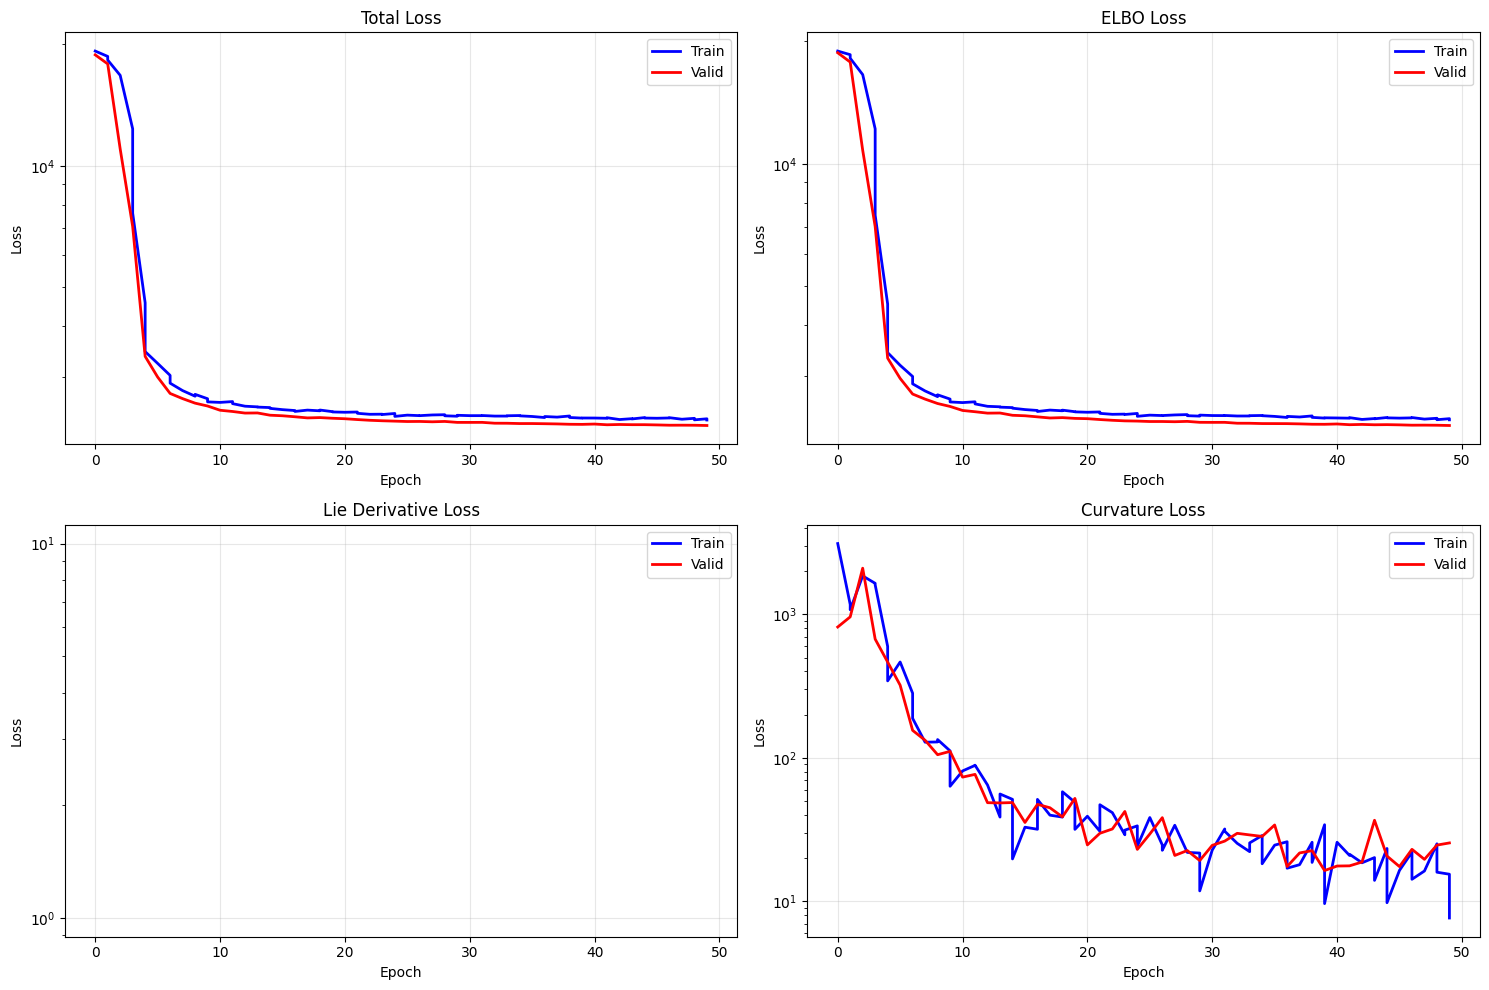

📊 Loss curves saved as 'regularized_loss_curves.png'


In [37]:
import pandas as pd
import glob

# Find the metrics CSV file
csv_files = glob.glob('logs_regularized/*/regularized/metrics.csv')
if csv_files:
    df = pd.read_csv(csv_files[0])
    
    # Create subplots for different loss components
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    # Total loss
    train_mask = ~df['train_loss'].isna()
    valid_mask = ~df['valid_loss'].isna()
    axes[0].plot(df[train_mask]['epoch'], df[train_mask]['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(df[valid_mask]['epoch'], df[valid_mask]['valid_loss'], 'r-', label='Valid', linewidth=2)
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')
    
    # ELBO loss
    train_elbo_mask = ~df['train_elbo'].isna()
    valid_elbo_mask = ~df['valid_elbo'].isna() 
    axes[1].plot(df[train_elbo_mask]['epoch'], df[train_elbo_mask]['train_elbo'], 'b-', label='Train', linewidth=2)
    axes[1].plot(df[valid_elbo_mask]['epoch'], df[valid_elbo_mask]['valid_elbo'], 'r-', label='Valid', linewidth=2)
    axes[1].set_title('ELBO Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')
    
    # Lie derivative loss
    train_lie_mask = ~df['train_lie'].isna()
    valid_lie_mask = ~df['valid_lie'].isna()
    axes[2].plot(df[train_lie_mask]['epoch'], df[train_lie_mask]['train_lie'], 'b-', label='Train', linewidth=2)
    axes[2].plot(df[valid_lie_mask]['epoch'], df[valid_lie_mask]['valid_lie'], 'r-', label='Valid', linewidth=2)
    axes[2].set_title('Lie Derivative Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_yscale('log')
    
    # Curvature loss
    train_curv_mask = ~df['train_curvature'].isna()
    valid_curv_mask = ~df['valid_curvature'].isna()
    axes[3].plot(df[train_curv_mask]['epoch'], df[train_curv_mask]['train_curvature'], 'b-', label='Train', linewidth=2)
    axes[3].plot(df[valid_curv_mask]['epoch'], df[valid_curv_mask]['valid_curvature'], 'r-', label='Valid', linewidth=2)
    axes[3].set_title('Curvature Loss')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Loss')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    axes[3].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('regularized_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Loss curves saved as 'regularized_loss_curves.png'")
else:
    print("⚠️ No metrics CSV file found")

## 🔍 Analyze Learned Dynamics

In [38]:
# Infer latent trajectories
with torch.no_grad():
    _, z_inferred_samples, _ = seq_vae.ssm(y, cfg.n_samples)
    z_inferred = z_inferred_samples.mean(dim=0)

print(f"✅ Inferred latents from observations")
print(f"   Inferred shape: {z_inferred.shape}")
print(f"   True shape: {z.shape}")

# Compute recovery metrics
mse = torch.mean((z_inferred - z)**2).item()
correlation = torch.corrcoef(torch.stack([z.flatten(), z_inferred.flatten()]))[0, 1].item()

print(f"📊 Recovery metrics:")
print(f"   MSE: {mse:.6f}")
print(f"   Correlation: {correlation:.4f}")

✅ Inferred latents from observations
   Inferred shape: torch.Size([3000, 75, 2])
   True shape: torch.Size([3000, 75, 2])
📊 Recovery metrics:
   MSE: 0.004976
   Correlation: 0.9951


## 🌟 Visualize Learned vs Target Dynamics

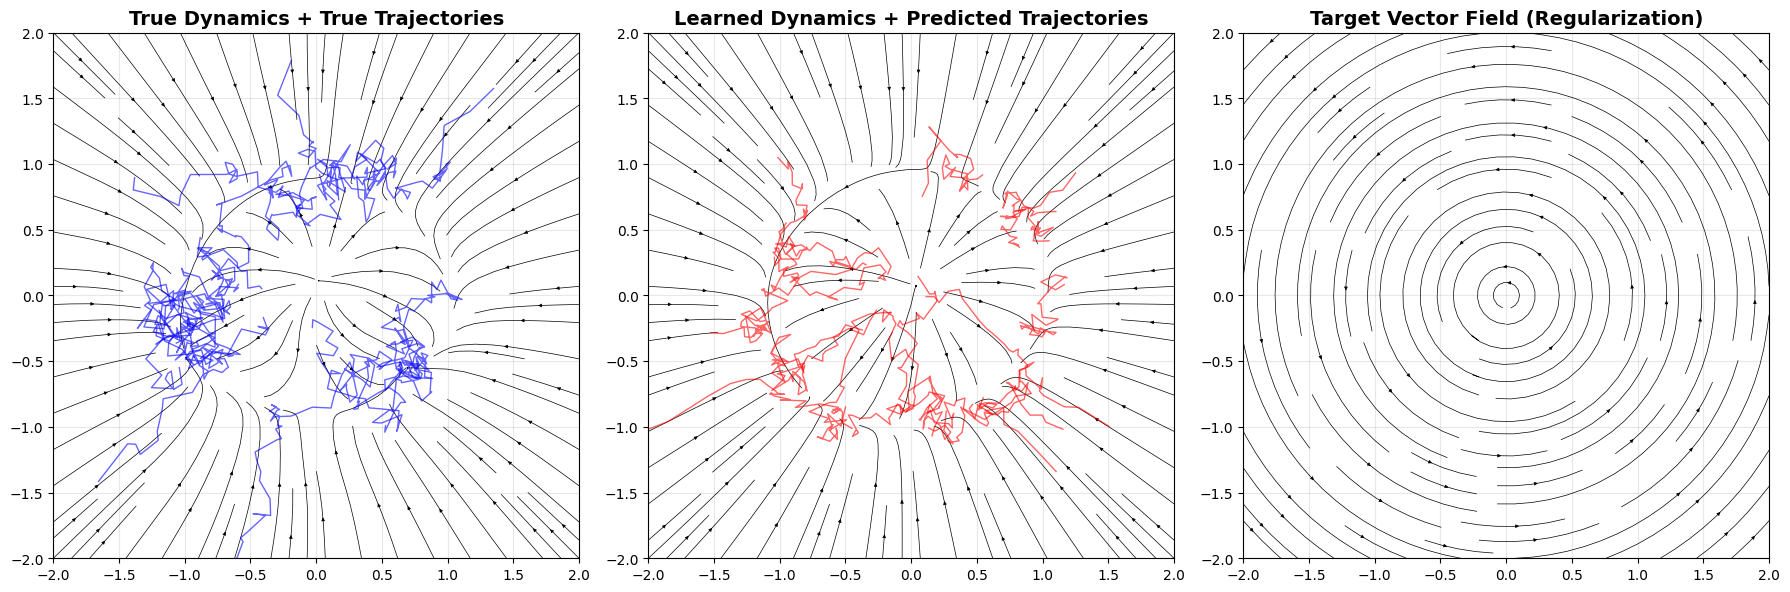

🌟 Dynamics comparison saved as 'dynamics_comparison.png'


In [39]:
# Generate autonomous trajectories from learned dynamics
n_rollout_trials = 20
n_rollout_time = 30

# Initial conditions
z_0 = torch.zeros((1, n_rollout_trials, 2))
z_0[:, ::2] = 0.3 * torch.randn_like(z_0[:, ::2])    # small amplitude
z_0[:, 1::2] = 1.5 * torch.randn_like(z_0[:, 1::2])  # large amplitude

# Predict forward
z_predicted = seq_vae.ssm.predict_forward(z_0, n_rollout_time).detach()

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. True dynamics + true trajectories
axes[0].set_title("True Dynamics + True Trajectories", fontsize=14, fontweight='bold')
plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), axes[0], min_xy=-2, max_xy=2)
for i in range(10):
    axes[0].plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), 'b-', alpha=0.6, linewidth=1)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_box_aspect(1.0)
axes[0].grid(True, alpha=0.3)

# 2. Learned dynamics + predicted trajectories
axes[1].set_title("Learned Dynamics + Predicted Trajectories", fontsize=14, fontweight='bold')
plot_utils.plot_two_d_vector_field(
    seq_vae.ssm.dynamics_mod.mean_fn, axes[1], min_xy=-2, max_xy=2
)
for i in range(n_rollout_trials):
    axes[1].plot(z_predicted[0, i, :, 0].cpu(), z_predicted[0, i, :, 1].cpu(), 
                'r-', alpha=0.6, linewidth=1)
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_box_aspect(1.0)
axes[1].grid(True, alpha=0.3)

# 3. Target vector field
axes[2].set_title("Target Vector Field (Regularization)", fontsize=14, fontweight='bold')
dt = 1e-2
plot_utils.plot_two_d_vector_field(
    lambda x: x + dt * target_vector_field(x), axes[2], min_xy=-2, max_xy=2
)
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].set_box_aspect(1.0)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dynamics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("🌟 Dynamics comparison saved as 'dynamics_comparison.png'")

## 📊 Final Loss Component Analysis

In [ ]:
# Get final loss components on validation set
final_losses = seq_vae.ssm.get_loss_components(y_valid, cfg.n_samples)

print("🔍 Final Loss Component Analysis:")
print(f"  Total Loss:      {final_losses['total_loss']:.6f}")
print(f"  ELBO Loss:       {final_losses['elbo_loss']:.6f}")
print(f"  Lie Loss:        {final_losses['lie_loss']:.6f}")
print(f"  Curvature Loss:  {final_losses['curvature_loss']:.6f}")
print(f"  Total Reg Loss:  {final_losses['total_reg_loss']:.6f}")

# Create a bar plot of loss components
components = ['ELBO', 'Lie Derivative', 'Curvature']
values = [final_losses['elbo_loss'], final_losses['lie_loss'], final_losses['curvature_loss']]
colors = ['blue', 'red', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(components, values, color=colors, alpha=0.7)
plt.title('Final Loss Components', fontsize=14, fontweight='bold')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('final_loss_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Final loss components saved as 'final_loss_components.png'")

## ✅ Training Complete!

### Summary

You have successfully trained a regularized state space model with:

1. **ELBO Loss**: Standard variational inference objective
2. **Lie Derivative Regularization**: Enforces similarity to target vector field
3. **Curvature Regularization**: Promotes smooth trajectories

### Key Files Generated:
- `regularized_loss_curves.png`: Training progress for all loss components  
- `dynamics_comparison.png`: True vs learned vs target dynamics
- `final_loss_components.png`: Final loss breakdown
- Model checkpoints in `ckpts_regularized/`
- Training logs in `logs_regularized/`

### Next Steps:
- Experiment with different regularization weights (`lambda_lie`, `lambda_curvature`)
- Try different target vector fields
- Compare regularized vs non-regularized models
- Analyze how regularization affects latent space geometry